In [68]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [69]:
# ================== Dataset ==================
class CarlaDataset(Dataset):
    def __init__(self, images, angles, signals, transform=None):
        self.images = images
        self.angles = angles
        self.signals = signals
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        angle = self.angles[idx]
        signal = self.signals[idx]

        if self.transform:
            img = self.transform(img)

        return (
            torch.tensor(img, dtype=torch.float32),
            torch.tensor(signal).unsqueeze(0),
            torch.tensor(angle, dtype=torch.float32)
        )


In [70]:
# ================== Model ==================
class SteeringModel(nn.Module):
    def __init__(self):
        super(SteeringModel, self).__init__()
        resnet = models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        for param in resnet.layer4.parameters():
            param.requires_grad = True

        self.cnn_backbone = nn.Sequential(*list(resnet.children())[:-1])  # (B, 512, 1, 1)

        self.signal_fc = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU()
        )

        self.fc_left = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.fc_right = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.fc_straight = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, signal):
        x = self.cnn_backbone(image)
        x = x.view(x.size(0), -1)
        s = self.signal_fc(signal)
        combined = torch.cat([x, s], dim=1)

        preds = torch.zeros(image.size(0), 1, device=image.device)
        left_mask = (signal.squeeze(1) == -1)
        right_mask = (signal.squeeze(1) == 1)
        straight_mask = (signal.squeeze(1) == 0)

        if left_mask.any():
            preds[left_mask] = self.fc_left(combined[left_mask])
        if right_mask.any():
            preds[right_mask] = self.fc_right(combined[right_mask])
        if straight_mask.any():
            preds[straight_mask] = self.fc_straight(combined[straight_mask])

        return preds.squeeze(1)

In [71]:
# ================== Loss ==================
class DirectionalWeightedMSE(nn.Module):
    def __init__(self, left_weight=0.0, right_weight=0.0, straight_weight=1.0):
        super().__init__()
        self.left_weight = left_weight
        self.right_weight = right_weight
        self.straight_weight = straight_weight

    def forward(self, preds, targets, signals):
        weights = torch.ones_like(targets)
        weights[signals.squeeze() == -1] = self.left_weight
        weights[signals.squeeze() == 1] = self.right_weight
        weights[signals.squeeze() == 0] = self.straight_weight
        loss = weights * (preds - targets) ** 2
        return loss.mean()

In [72]:
# ================== Load Data ==================
images = np.load('../output/all_images.npy')         # (N, 3, 224, 224)
angles = np.load('../output/all_angles.npy').astype(np.float32)
signals = np.load('../output/all_turn_signals.npy').astype(np.float32)

train_idx, val_idx = train_test_split(
    np.arange(len(images)),
    test_size=0.2,
    shuffle=False  # No shuffling for time series data
)

train_data = (images[train_idx], angles[train_idx], signals[train_idx])
val_data   = (images[val_idx],   angles[val_idx],   signals[val_idx])

In [73]:
# ================== Transforms ==================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std= [0.229, 0.224, 0.225]
    )
])

In [77]:
# ================== Dataloaders ==================
train_dataset = CarlaDataset(*train_data, transform=transform)
val_dataset   = CarlaDataset(*val_data,   transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

# ================== Training Setup ==================
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = SteeringModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# criterion = DirectionalWeightedMSE()
criterion = nn.MSELoss()

# Prepare checkpointing
os.makedirs("../models", exist_ok=True)
checkpoint_path = "../models/RDModel_checkpoint.pth"
start_epoch     = 1
num_epochs      = 25

if os .path.isfile(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['opt_state'])
    start_epoch     = ckpt['epoch'] + 1
    best_val_loss   = ckpt['best_val']
    print(f"Loaded checkpoint: resuming from epoch {start_epoch}, best val loss = {best_val_loss:.4f}")
else:
    best_val_loss = float('inf')

train_losses = []
val_losses   = []

In [78]:

# ================== Training Loop ==================
for epoch in range(start_epoch, num_epochs + 1):
    # — Training —
    model.train()
    total_train_loss = 0.0
    for imgs, sigs, angs in train_loader:
        imgs, sigs, angs = imgs.to(device), sigs.to(device), angs.to(device)

        optimizer.zero_grad()
        preds = model(imgs, sigs)
        # loss = criterion(preds, angs, sigs)
        loss = criterion(preds, angs)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # — Validation —
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for imgs, sigs, angs in val_loader:
            imgs, sigs, angs = imgs.to(device), sigs.to(device), angs.to(device)
            preds = model(imgs, sigs)
            # loss = criterion(preds, angs, sigs)
            loss = criterion(preds, angs)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # — Checkpoint if improved —
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint = {
            'epoch':       epoch,
            'model_state': model.state_dict(),
            'opt_state':   optimizer.state_dict(),
            'best_val':    best_val_loss,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"  → Saved checkpoint (val loss {best_val_loss:.4f})")

C:\Users\Pravin\AppData\Local\Temp\ipykernel_27084\1552530543.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(img, dtype=torch.float32),


Epoch 1 | Train Loss: 0.0138 | Val Loss: 0.0103
  → Saved checkpoint (val loss 0.0103)
Epoch 2 | Train Loss: 0.0080 | Val Loss: 0.0136


KeyboardInterrupt: 

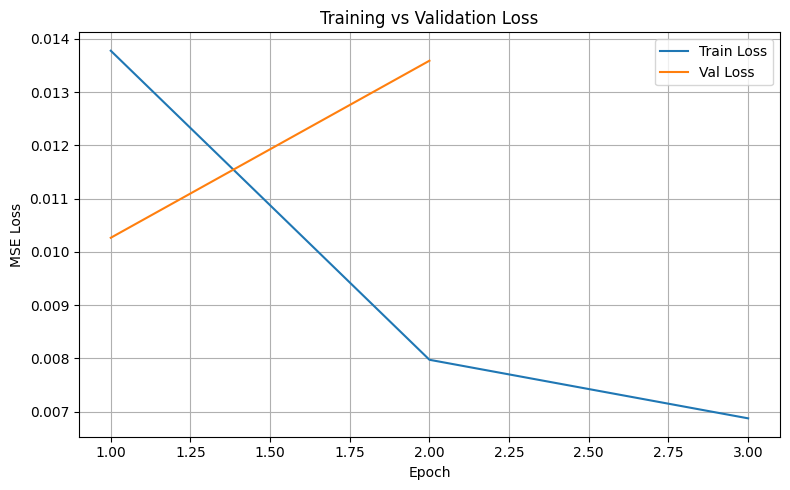

In [79]:
# ================== Plot Loss ==================
plt.figure(figsize=(8,5))
plt.plot(range(start_epoch, start_epoch + len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(start_epoch, start_epoch + len(val_losses)),   val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curves.png")
plt.show()

RDModel_checkpoint.pth, how do lower the learning rate and train it with another set of data
Here’s a minimal example of how to

1. load your existing checkpoint.
2. drop the LR to 1e-5,
3. point to a new dataset,
4. and continue training.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Instantiate your model & optimizer
model     = SteeringModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)   # dummy lr for now
# criterion = DirectionalWeightedMSE()
criterion = nn.MSELoss()

# 2) Load checkpoint
ckpt = torch.load("../Models/RDModel_checkpoint.pth", map_location=device)
model.load_state_dict(ckpt['model_state'])
optimizer.load_state_dict(ckpt['opt_state'])
print(f"Loaded checkpoint from epoch {ckpt['epoch']} (best_val={ckpt['best_val']:.4f})")

Loaded checkpoint from epoch 6 (best_val=0.0055)


In [ ]:
# 3) Lower the learning rate for fine-tuning
for pg in optimizer.param_groups:
    pg['lr'] = 1e-5
print("New learning rates:", [pg['lr'] for pg in optimizer.param_groups])

New learning rates: [1e-05]


In [ ]:
# 4) Prepare your new dataset
new_images  = np.load("../output/std_images.npy")       # shape (N,3,224,224)
new_angles  = np.load("../output/std_angles.npy").astype(np.float32)
new_signals = np.load("../output/std_turn_signals.npy").astype(np.float32)

In [ ]:
# optional: split into train/val
train_idx, val_idx = train_test_split(
    np.arange(len(new_images)),
    test_size=0.2, shuffle=False
)

In [ ]:
train_data = (new_images[train_idx], new_angles[train_idx], new_signals[train_idx])
val_data   = (new_images[val_idx],   new_angles[val_idx],   new_signals[val_idx])

In [ ]:
# reuse your transforms
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


In [ ]:

train_loader = DataLoader(
    CarlaDataset(*train_data, transform=transform),
    batch_size=32, shuffle=False
)
val_loader = DataLoader(
    CarlaDataset(*val_data, transform=transform),
    batch_size=32, shuffle=False
)

In [ ]:
# 5) Continue fine-tuning
extra_epochs = 0
for epoch in range(ckpt['epoch']+1, ckpt['epoch'] + extra_epochs + 1):
    model.train()
    total_train = 0.0
    for imgs, sigs, angs in train_loader:
        imgs, sigs, angs = imgs.to(device), sigs.to(device), angs.to(device)
        optimizer.zero_grad()
        preds = model(imgs, sigs)
        # loss  = criterion(preds, angs, sigs)
        loss = criterion(preds, angs)
        loss.backward()
        optimizer.step()
        total_train += loss.item()
    avg_train = total_train / len(train_loader)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for imgs, sigs, angs in val_loader:
            imgs, sigs, angs = imgs.to(device), sigs.to(device), angs.to(device)
            # total_val += criterion(model(imgs, sigs), angs, sigs).item()
            total_val += criterion(preds, angs).item()
    avg_val = total_val / len(val_loader)

    print(f"[Epoch {epoch}] Train: {avg_train:.4f}  Val: {avg_val:.4f}")


In [80]:
torch.save(
    model.state_dict(),
    "../models/RDModel_finetuned.pth"
)
print("Saved fine-tuned weights to ../models/RDModel_finetuned.pth")

Saved fine-tuned weights to ../models/RDModel_finetuned.pth
